# Classification Iris Species

In [56]:
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import RidgeClassifierCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

## Чтение данных

In [57]:
df = pd.read_csv('./Iris.csv', header = None, encoding = 'utf-8')
df.head()

,0,1,2,3,4,5
0,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
1,1,5.1,3.5,1.4,0.2,Iris-setosa
2,2,4.9,3.0,1.4,0.2,Iris-setosa
3,3,4.7,3.2,1.3,0.2,Iris-setosa
4,4,4.6,3.1,1.5,0.2,Iris-setosa


### Рассмотрим 100 первых значений, содержащих два вида цветков: 
- Iris-setosa - Ирис-шетинистый
- Iris-versicolor - Ирис-разноцветный

### Рассмотрим такие признаки как длина чашелистника и длина лепестка
### Преобразуем категориальную переменную

In [58]:
y = df.iloc[1:100, 5].values
y = np.where(y == 'Iris-setosa', 0, 1)
X = df.iloc[1:100, [1, 3]].values.astype(float)

In [59]:
df = pd.DataFrame(X, columns = ['SepalLengthCm','PetalLengthCm'])
df['target'] = y

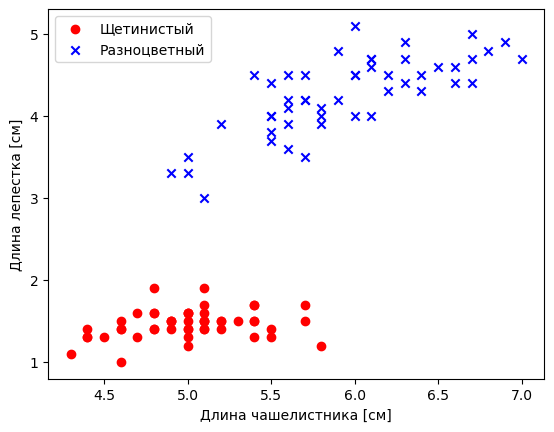

In [61]:
plt.scatter(df.iloc[:50, 0], df.iloc[:50, 1], 
           color = 'red', marker = 'o', label = 'Щетинистый')
plt.scatter(df.iloc[50:, 0], df.iloc[50:, 1], 
           color = 'blue', marker = 'x', label = 'Разноцветный')
plt.xlabel('Длина чашелистника [см]')
plt.ylabel('Длина лепестка [см]')
plt.legend(loc='upper left')
plt.show()

## EDA

In [62]:
df.head(5)

,SepalLengthCm,PetalLengthCm,target
0,5.1,1.4,0
1,4.9,1.4,0
2,4.7,1.3,0
3,4.6,1.5,0
4,5.0,1.4,0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  99 non-null     float64
 1   PetalLengthCm  99 non-null     float64
 2   target         99 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 2.4 KB


In [64]:
df.describe()


,SepalLengthCm,PetalLengthCm,target
count,99.000000,99.000000,99.000000
mean,5.468687,2.849495,0.494949
std,0.644545,1.450501,0.502519
min,4.300000,1.000000,0.000000
25%,5.000000,1.500000,0.000000
50%,5.400000,1.900000,0.000000
75%,5.900000,4.350000,1.000000
max,7.000000,5.100000,1.000000


In [65]:
df.groupby('target').mean()

,SepalLengthCm,PetalLengthCm
target,,
0,5.006000,1.464000
1,5.940816,4.263265


## 🚩Разбиение данных с использованием train_test_split и масштабирование

In [66]:
y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train.head(5)

,SepalLengthCm,PetalLengthCm
0,0.000000,0.704022
1,-0.149525,-0.891061
2,-1.046675,-1.099116
3,0.149525,0.634671
4,-0.747625,-1.237818


### Отбор наилучших признаков с помощью рекурсивного исключения признаков и кросс-валидации (RFECV)

In [67]:
rfecv = RFECV(estimator=RidgeClassifierCV())

rfecv.fit(X_train, y_train)

selected_features = list(X_train.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", selected_features)

Optimal features:  1
Selected features:  ['PetalLengthCm']


In [68]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [69]:
X_train.head(5)

,PetalLengthCm
0,0.704022
1,-0.891061
2,-1.099116
3,0.634671
4,-1.237818


## Метод k-ближайших соседей. Реализация в классе KNN_Classifier

In [70]:
class KNN_Classifier(object):
    def __init__(self, num_neighbors=5):
        self._num_neighbors = num_neighbors
        self.y_pred = []
    
    def euclidean_distance(self, row, data):                      #получение расстояний для одной строки
        distances = np.array([])
        for i in range(data.shape[0]):
            distances = np.append(distances, (np.sqrt(((data[i] - row)**2).sum())))
        return distances.reshape(data.shape[0], )                 #возвращаем столбец

    def get_neighbors(self, distances, y):                     #выделение необходимых соседей и их метрик
        neighbours = np.column_stack([distances, y])            #присоединяем к столбцу расстояний метки классов этих строк
        neighbours = neighbours[np.argsort(neighbours[:, 0])]
        
        prediction = self.predict(neighbours[:self._num_neighbors, :])
        return prediction
    
    def predict(self, neighbors):
        vals, counts = np.unique(neighbors[:, -1:], return_counts=True)
        return (vals[np.argmax(counts)])
    
    def fit(self, X_train, X_test, y_train): #предсказываем тестовые значения на тренировочных данных
        for i in range(X_test.shape[0]):
            distances = self.euclidean_distance(X_test[i], X_train)
            self.y_pred.append(self.get_neighbors(distances, y_train))
        return self
    
    def accuracy(self, y):
        correct = 0
        for i in range(y.shape[0]):
#             if y.values[i] == self.y_pred[i]:
            if y[i] == self.y_pred[i]:
                correct += 1
        return (correct / (y.shape[0]))
    
    def get_params(self, deep=True):
        return {"num_neighbors": self._num_neighbors}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [71]:
knn = KNN_Classifier(3)

knn_fit = knn.fit(X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy())
knn_fit.y_pred[:10]


[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

In [72]:
y_test[:10]

62    1
40    0
95    1
18    0
97    1
84    1
64    1
42    0
10    0
0     0
Name: target, dtype: int64

In [73]:
accuracy_score(y_test, knn_fit.y_pred)

1.0

In [74]:
from sklearn.model_selection import KFold

# датасет
data = np.vstack([X_train, X_test])
target = np.concatenate([y_train, y_test])
data = np.column_stack([data, target])

res_table = pd.DataFrame({'#':['k-neighbours', 'accuracy-score']})

# подготовьте кросс валидацию
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
num_neighbours = [3, 5, 7, 9]
i = 1

best_acc = 0
nbrs = 0
idx = 0

# перечисление выборок датасета
for k in num_neighbours:
    i = 1
    for train, test in kfold.split(data):
        knn = KNN_Classifier(k)
        knn_fit = knn.fit(data[train], data[test], data[:, -1:][train])
        acc = knn.accuracy(data[:, -1:][test])
        row = [k, acc]
        res_table[f"Split-{i}.{k}"] = row
        if acc > best_acc:
            best_acc = acc  
            nbrs = k
            idx = i
        i+=1


In [75]:
print(f'Наилучшая точность %.4f достигается при %.f соседях на %.f сплите' % (best_acc, nbrs, idx))

Наилучшая точность 1.0000 достигается при 3 соседях на 1 сплите


In [76]:
res_table.iloc[:, :10]

,#,Split-1.3,Split-2.3,Split-3.3,Split-4.3,Split-5.3,Split-1.5,Split-2.5,Split-3.5,Split-4.5
0,k-neighbours,3.0,3.0,3.0,3.0,3.0,5.0,5.0,5.0,5.0
1,accuracy-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Проверка выполнения алгоритма с помощью библиотечных реализаций
***(logistic regression, svm, knn, naive bayes, decision tree)***

### Sklearn: LogisticRegression

In [77]:
from sklearn.linear_model import LogisticRegression
accuracies = {}

lr = LogisticRegression()
lr.fit(X_train, y_train)
acc = lr.score(X_test, y_test)

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 1.0000


### Sklearn: SVM

In [78]:
from sklearn.svm import SVC

svm = SVC(random_state = 12)
svm.fit(X_train, y_train)

acc = svm.score(X_test, y_test)
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 1.0000


### Sklearn: KNeighborsClassifier

In [79]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)  # n_neighbors means k
knn.fit(X_train, y_train)
prediction = knn.predict(X_test)

print("{} NN Score: {:.4f}".format(3, knn.score(X_test, y_test)))

3 NN Score: 1.0000


### Sklearn: naive_bayes

In [80]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

acc = nb.score(X_test, y_test)
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.4f}".format(acc))

Accuracy of Naive Bayes: 1.0000


### Sklearn: DecisionTreeClassifier

In [81]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

acc = dtc.score(X_test, y_test)
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.4f}".format(acc))

Decision Tree Test Accuracy 1.0000


## Confusion matrices

In [82]:
# Predicted values
my_knn = best_acc
y_head_lr = lr.predict(X_test)
knn3 = KNeighborsClassifier(n_neighbors = 3)
knn3.fit(X_train, y_train)
y_head_knn = knn3.predict(X_test)
y_head_svm = svm.predict(X_test)
y_head_nb = nb.predict(X_test)
y_head_dtc = dtc.predict(X_test)
knn = KNN_Classifier(3)
knn_fit = knn.fit(X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy())
y_head_knnc = knn_fit.y_pred

In [83]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_svm = confusion_matrix(y_test, y_head_svm)
cm_nb = confusion_matrix(y_test, y_head_nb)
cm_dtc = confusion_matrix(y_test, y_head_dtc)
cm_knnc = confusion_matrix(y_test, y_head_knnc)

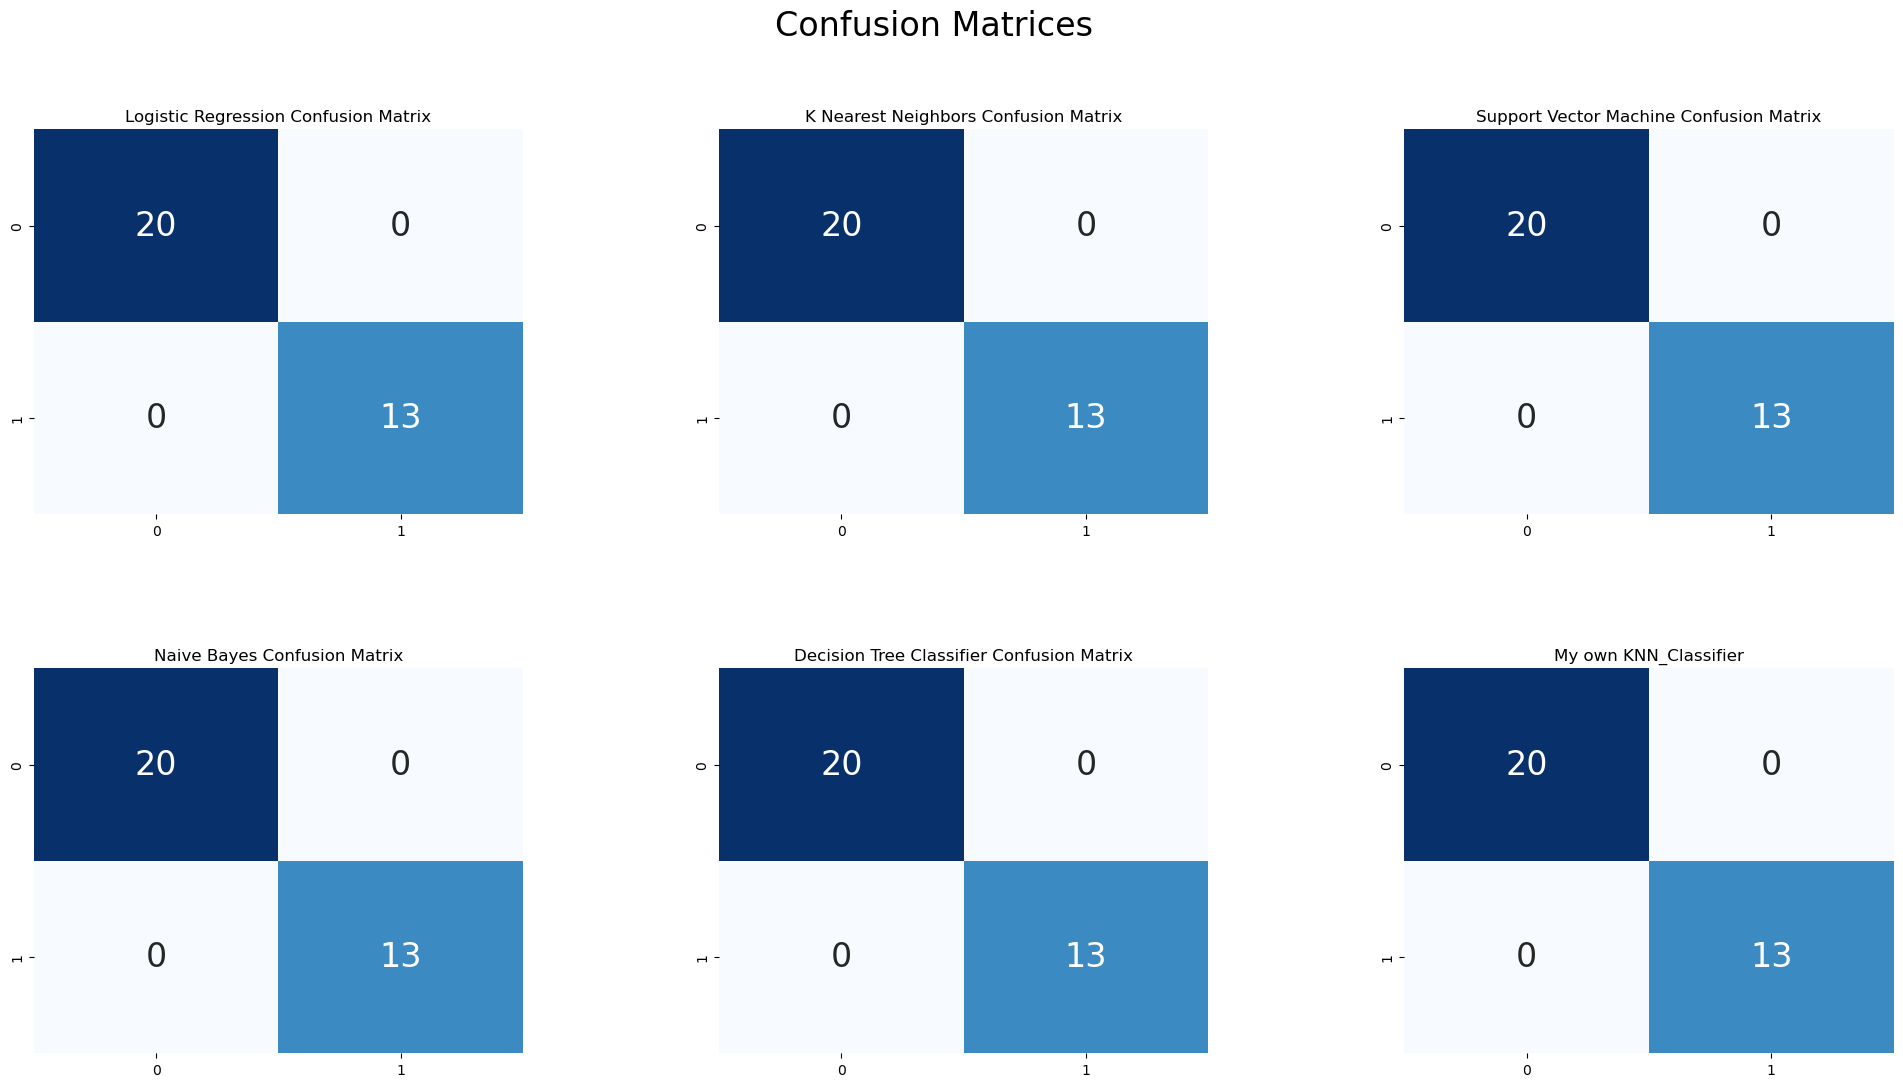

In [84]:
plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,6)
plt.title("My own KNN_Classifier")
sns.heatmap(cm_knnc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

### Матрица разработанного решения(правый нижний угол) полностью совпадает с библиотечной реализацией KNN. Наилучшие показатели у Decision Tree Classifier.

## Logistic Regression. Реализация в классе LogR_Classifier

In [85]:
class LogR_Classifier(object):
    
    def __init__(self, n_iter = 100, learning_rate = 0.01):
        self.w = None
        self.b = 0.1
        self.n_iter = n_iter
        self.lr = learning_rate
        
    def fit(self, X, y):

        n = X.shape[0]
        m = X.shape[1]
        self.w = np.random.uniform(0,1, m) # colom 1
        print('w', self.w.shape)
        
        for i in range(10000):
            z = X.dot(self.w) + self.b
            y_pred = self.sigmoid(z)
            l = self.square_loss(y_pred, y)        
            gradient_W = np.dot((y_pred-y).T, X)/m
            gradient_b = np.mean(y_pred-y)
            self.w -= self.lr * gradient_W
            self.b -= self.lr * gradient_b
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def square_loss(self, y_pred, target):
        return np.mean((y_pred - target)**2)
    
    def predict(self, X):
        res = np.array([])
        res = np.append(res, self.sigmoid(np.dot(X, self.w) + self.b))
        return np.where(res >= 0.5, 1, 0)

In [86]:
X_train.shape

(66, 1)

In [87]:
logr = LogR_Classifier(100, 0.01)
logr_fit = logr.fit(X_train.to_numpy(), y_train.to_numpy())

w (1,)


In [88]:
y_pred = logr.predict(X_train)
y_pred[:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1])

In [89]:
y_pred.shape

(66,)

In [90]:
y_train[:10]

89    1
5     0
45    0
69    1
35    0
16    0
72    1
34    0
7     0
55    1
Name: target, dtype: int64

In [91]:
accuracy_score(y_train, y_pred)

1.0

In [92]:
y_pred_test = logr.predict(X_test)
accuracy_score(y_test, y_pred_test)

1.0